<a href="https://colab.research.google.com/github/barauna-lo/Neurocomputing/blob/main/Project_03_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src=https://raw.githubusercontent.com/barauna-lo/CAP4213-Deep-Learning/main/logoinpe.png align=”middle”>](https://www.gov.br/inpe/pt-br)

[<center><img src="https://github.com/barauna-lo/Deep-Learning/blob/main/LogoCAP.png?raw=true" width = 450 align="middle"></center>](http://www.inpe.br/posgraduacao/cap/)


# Project 03 - VARIATIONAL AUTO ENCODER (VAE)

* [Luan Orion Baraúna](https://www.linkedin.com/in/luan-orion-barauna/)


## PROJETO 3 – VARIATIONAL AUTO ENCODER (VAE)

1. Selecionar 2 datasets (rotulados)

2. Treinar modelos VAEs:

  2.1. Ajustar o melhor modelo (topologia) segundo a
função de custo (conjunto validação)

3. Explorar o espaço latente:

  3.1. Gerar gráficos com a projeção do espaço latente
em 2D (PCA)

  3.2 Usar os rótulos na projeção

### Algumas questões:

1. Há formação de clusters no espaço latente?

2. Há separação dos rótulos no espaço latente?

3. A projeção ilustra quanto da variância?

**Adicional (opcional)**: Enviesar a formação do
espaço latente com os exemplos rotulados


# Introduction 

O autoencoder é um algoritimo que possui uma extrutura arquitetônica semelhante ao 


<img src="https://uploads-ssl.webflow.com/5fff737782367c2909ecca82/602e565b1047f73f66f60f73_s-vae-gifs.gif">

font: https://en.wikipedia.org/wiki/Self-organizing_map


# Metodology 



## Parametes Explorations


## Datasets



## Plots and Results



## Extras



https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb#scrollTo=4pVFzJmgngfE

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1. Selecionar 2 datasets (rotulados)



In [14]:
data1 = keras.datasets.mnist.load_data()
data2 = keras.datasets.fashion_mnist.load_data()

In [11]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Plot Functions 




def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()



### VAE Model 1

In [ ]:
latent_dim = 2

# Build the encoder

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")


# Build the decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# encoder.summary()
# decoder.summary()

# Define the VAE as a Model with a custom train_step


1. 

In [ ]:
(x_train, _), (x_test, _) = data1
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)


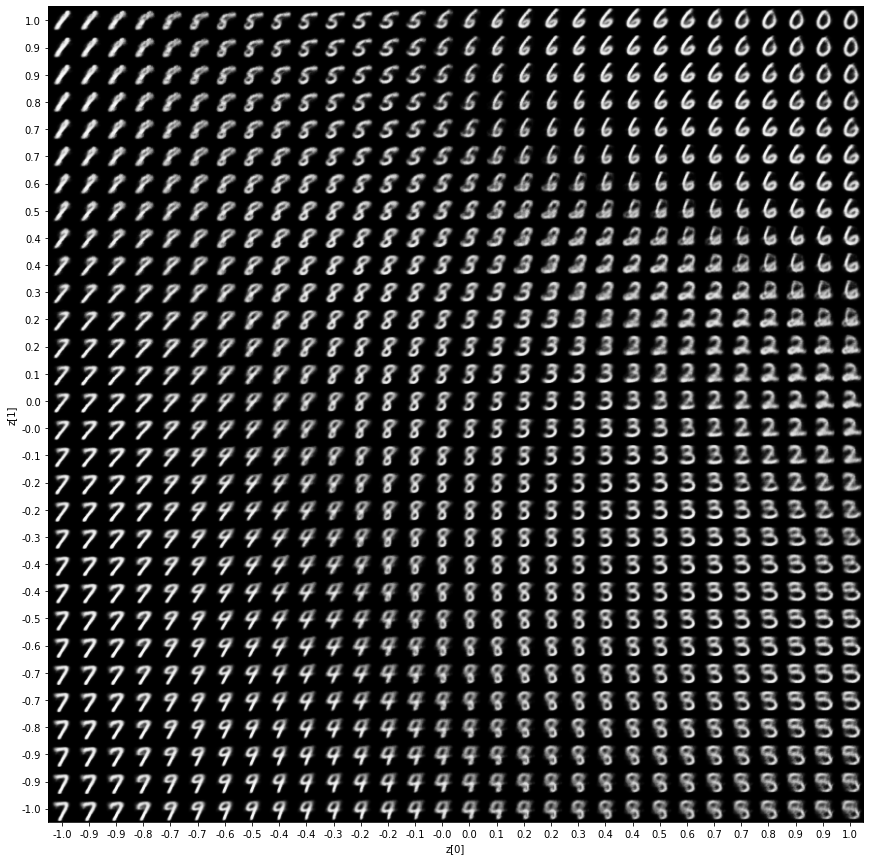

In [7]:
#plot 

plot_latent_space(vae)


In [ ]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

In [ ]:
data = x_train
labels = y_train
z_mean, _, _ = vae.encoder.predict(data)

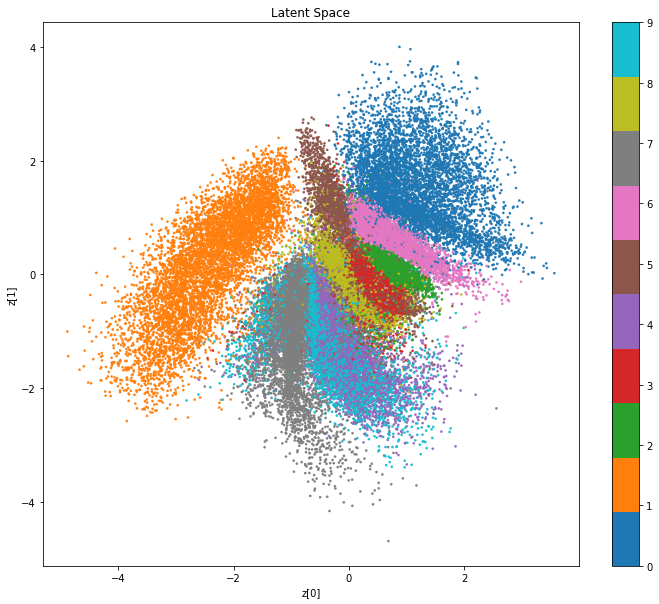

In [53]:
# plot_label_clusters(vae, x_train, y_train)


col_dict={0:"C0",
          1:"C1",
          2:"C2",
          3:"C3",
          4:"C4",
          5:"C5",
          6:"C6",
          7:"C7",
          8:"C8",
          9:"C9",
          }     
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])    

def plot_label_clusters(vae, data, labels,cmap=col_dict,s=cm):
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels,cmap=cmap,s=s,linewidths=0.3)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title('Latent Space')
    plt.show()

plot_label_clusters(vae,x_train,y_train,cm,5)


In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# if not tf.config.list_physical_devices('GPU'):
#     print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
#     if IS_COLAB:
#         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
#     if IS_KAGGLE:
#         print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
#AUTO ENCONDER

tf.random.set_seed(42)
np.random.seed(42)

#CODER
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
#DECODER
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
# variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
# history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
#                              validation_data=(X_valid, X_valid))

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
K = keras.backend
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [ ]:
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 18s 33ms/step - loss: 0.3893 - rounded_accuracy: 0.8610 - val_loss: 0.3648 - val_rounded_accuracy: 0.8865
Epoch 2/25
430/430 [==============================] - 13s 30ms/step - loss: 0.3427 - rounded_accuracy: 0.8978 - val_loss: 0.3394 - val_rounded_accuracy: 0.9029
Epoch 3/25
430/430 [==============================] - 17s 39ms/step - loss: 0.3323 - rounded_accuracy: 0.9053 - val_loss: 0.3304 - val_rounded_accuracy: 0.9059
Epoch 4/25
430/430 [==============================] - 14s 32ms/step - loss: 0.3273 - rounded_accuracy: 0.9092 - val_loss: 0.3304 - val_rounded_accuracy: 0.9108
Epoch 5/25
430/430 [==============================] - 10s 23ms/step - loss: 0.3242 - rounded_accuracy: 0.9116 - val_loss: 0.3286 - val_rounded_accuracy: 0.9110
Epoch 6/25
430/430 [==============================] - 9s 22ms/step - loss: 0.3220 - rounded_accuracy: 0.9136 - val_loss: 0.3225 - val_rounded_accuracy: 0.9126
Epoch 7/25
430/430 [=====================

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")        

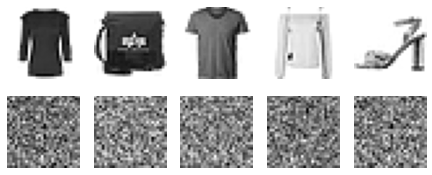

In [ ]:
show_reconstructions(variational_ae)
plt.show()


In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = variational_ae.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


ValueError: ignored

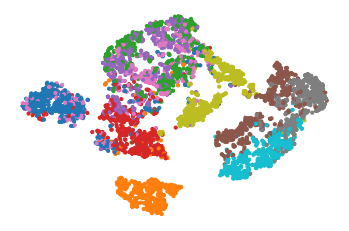

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

In [ ]:
!git clone https://github.com/barauna-lo/Neurocomputing.git

Cloning into 'Neurocomputing'...
remote: Enumerating objects: 288, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 288 (delta 107), reused 114 (delta 70), pack-reused 109
Receiving objects: 100% (288/288), 219.98 MiB | 11.03 MiB/s, done.
Resolving deltas: 100% (161/161), done.
Checking out files: 100% (17/17), done.


In [ ]:
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
print(tf.__version__)
from tf.keras.datasets import mnist

In [ ]:
print(tf. __version__) 

2.8.2


In [ ]:
cd Neurocomputing/

/content/Neurocomputing


In [ ]:
# !pip install tensorflow==1.14.0
# import tensorflow as tf
print(tf.__version__)

2.8.2


In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [ ]:
import os
import pickle

import tensorflow as tf

assert tf.__version__ >= "2.8.0"


In [ ]:


tf.compat.v1.disable_eager_execution()

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
#import tensorflow as tf


#tf.compat.v1.disable_eager_execution()


class VAE:
    """
    VAE represents a Deep Convolutional variational autoencoder architecture
    with mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
        self.input_shape = input_shape # [28, 28, 1]
        self.conv_filters = conv_filters # [2, 4, 8]
        self.conv_kernels = conv_kernels # [3, 5, 3]
        self.conv_strides = conv_strides # [1, 2, 2]
        self.latent_space_dim = latent_space_dim # 2
        self.reconstruction_loss_weight = 1000

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build()

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()

    def compile(self, learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer,
                           loss=self._calculate_combined_loss,
                           metrics=[self._calculate_reconstruction_loss,
                                    self._calculate_kl_loss])

    def train(self, x_train, batch_size, num_epochs):
        self.model.fit(x_train,
                       x_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       shuffle=True)

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def reconstruct(self, images):
        latent_representations = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(latent_representations)
        return reconstructed_images, latent_representations

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def _calculate_combined_loss(self, y_target, y_predicted):
        reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
        kl_loss = self._calculate_kl_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss\
                                                         + kl_loss
        return combined_loss

    def _calculate_reconstruction_loss(self, y_target, y_predicted):
        error = y_target - y_predicted
        reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3],name="new_loss")
        return reconstruction_loss

    def _calculate_kl_loss(self, y_target, y_predicted):
        kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) -
                               K.exp(self.log_variance), axis=1)
        return kl_loss

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")

    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self, x):
        """Add conv transpose blocks."""
        # loop through all the conv layers in reverse order and stop at the
        # first layer
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        return output_layer

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        """Create all convolutional blocks in encoder."""
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        """Add a convolutional block to a graph of layers, consisting of
        conv 2d + ReLU + batch normalization.
        """
        layer_number = layer_index + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        """Flatten data and add bottleneck with Guassian sampling (Dense
        layer).
        """
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        self.mu = Dense(self.latent_space_dim, name="mu")(x)
        self.log_variance = Dense(self.latent_space_dim,
                                  name="log_variance")(x)

        def sample_point_from_normal_distribution(args):
            mu, log_variance = args
            epsilon = K.random_normal(shape=K.shape(self.mu), mean=0.,
                                      stddev=1.)
            sampled_point = mu + K.exp(log_variance / 2) * epsilon
            return sampled_point

        x = Lambda(sample_point_from_normal_distribution,
                   name="encoder_output")([self.mu, self.log_variance])
        return x


if __name__ == "__main__":
    autoencoder = VAE(
        input_shape=(28, 28, 1),
        conv_filters=(32, 64, 64, 64),
        conv_kernels=(3, 3, 3, 3),
        conv_strides=(1, 2, 2, 1),
        latent_space_dim=2
    )
    autoencoder.summary()




Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_conv_layer_1 (Conv2D)  (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 encoder_relu_1 (ReLU)          (None, 28, 28, 32)   0           ['encoder_conv_layer_1[0][0]']   
                                                                                                  
 encoder_bn_1 (BatchNormalizati  (None, 28, 28, 32)  128         ['encoder_relu_1[0][0]']         
 on)                                                                                        

In [ ]:
print(tf.__version__)

2.8.2


In [ ]:
tf

<module 'tensorflow' from '/usr/local/lib/python3.7/dist-packages/tensorflow/__init__.py'>

In [ ]:
from keras.datasets import mnist

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#from autoencoder import VAE

LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 100


def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype("float32") / 255
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.astype("float32") / 255
    x_test = x_test.reshape(x_test.shape + (1,))

    return x_train, y_train, x_test, y_test


def train(x_train, learning_rate, batch_size, epochs):
    autoencoder = VAE(
        input_shape=(28, 28, 1),
        conv_filters=(32, 64, 64, 64),
        conv_kernels=(3, 3, 3, 3),
        conv_strides=(1, 2, 2, 1),
        latent_space_dim=2
    )
    autoencoder.summary()
    autoencoder.compile(learning_rate)
    autoencoder.train(x_train, batch_size, epochs)
    return autoencoder



In [ ]:

if __name__ == "__main__":
    x_train, _, _, _ = load_mnist()
    autoencoder = train(x_train[:10000], LEARNING_RATE, BATCH_SIZE, EPOCHS)
    autoencoder.save("model")

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_conv_layer_1 (Conv2D)  (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 encoder_relu_1 (ReLU)          (None, 28, 28, 32)   0           ['encoder_conv_layer_1[0][0]']   
                                                                                                  
 encoder_bn_1 (BatchNormalizati  (None, 28, 28, 32)  128         ['encoder_relu_1[0][0]']         
 on)                                                                                        

AttributeError: ignored

In [ ]:
x_train, _, _, _ = load_mnist()
autoencoder = train(x_train[:10000], LEARNING_RATE, BATCH_SIZE, EPOCHS)
autoencoder.save("model")

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
!pip install tensorflow==1.14.0
%tensorflow_version 1.x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-1.14.0-cp37-cp37m-manylinux1_x86_64.whl (109.3 MB)
  Using cached tensorflow_estimator-1.14.0-py2.py3-none-any.whl (488 kB)
  Using cached tensorboard-1.14.0-py3-none-any.whl (3.1 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.0
    Uninstalling tensorboard-2.10.0:
      Successfully uninstalled tensorboard-2.10.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

ValueError: ignored

# 1- Iris dataset

<img src="https://miro.medium.com/max/1000/1*nfK3vGZkTa4GrO7yWpcS-Q.png">

The dataset consists of 50 samples from each of the three Iris species (Iris setosa, Iris virginica and Iris versicolor). Four variables were measured in each sample: the length and width of the sepals and petals, in centimeters. Based on the combination of these four characteristics, Fisher developed a linear discriminant model to distinguish species from one another.

In [ ]:
import numpy as np
import pandas as pd
import sklearn.datasets
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
import matplotlib.gridspec as gridspec
#import matplotlib.gridspec as gridspec
#from plotnine import *
import sys
sys.path.insert(0, '../')

## Pre-Processing

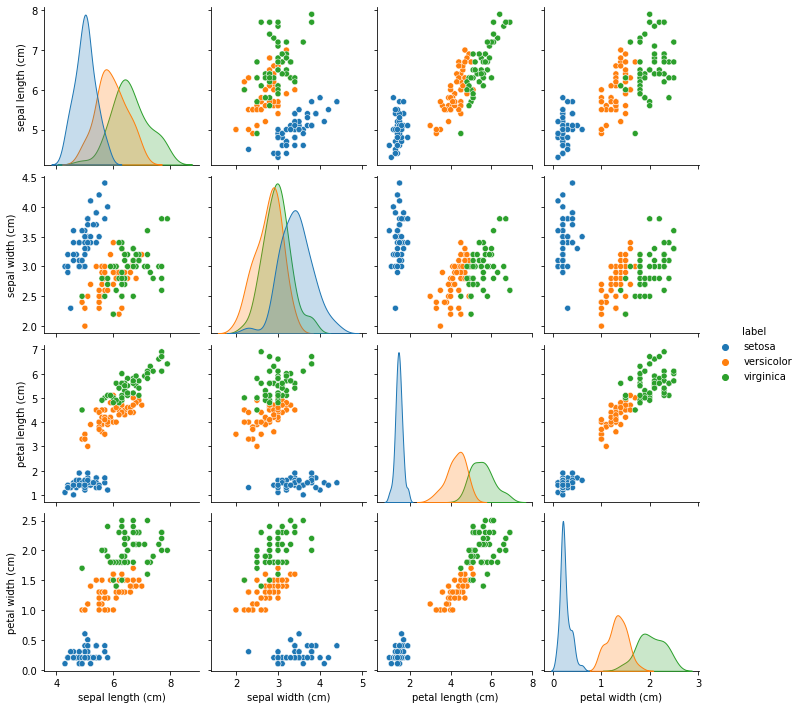

In [ ]:
iris = sklearn.datasets.load_iris()
df = pd.DataFrame(iris.data, columns = iris.feature_names)
df['label'] = [iris.target_names[i] for i in iris.target]
sns.pairplot(df, hue = 'label')

In [ ]:
features = df.drop(['label'], axis=1)
#Normaling data
scaler = MinMaxScaler() 
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
data = features
labels = df.label.unique()
instances = df['label'].unique()
instances.shape[0]
#Tranforming the data for numerical values
df['label'].replace(df['label'].unique(),
                        [0,1,2], inplace=True)
target = df['label'].values


Text(0.5, 1.0, 'Correation Map')

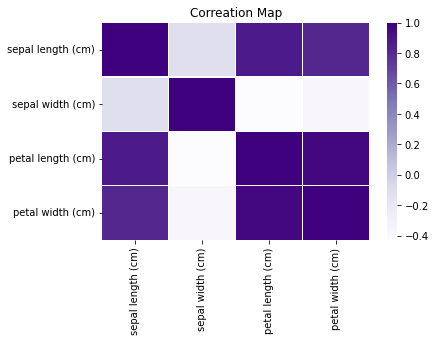

In [ ]:
sns.heatmap(features.astype(float).corr(), linewidths = 0.1, linecolor = 'white', cmap="Purples")
plt.title('Correation Map')

In [ ]:
# Models Paramentes 🎛️
sigma          = [.01,0.5,1,1.5,2,
                  .01,0.5,1,1.5,2,
                  .01,0.5,1,1.5,2,
                  .01,0.5,1,1.5,2,
                  .01,0.5,1,1.5,2,]
learning_rate  = [.01,.01,.01,.01,.01,
                  .25,.25,.25,.25,.25,
                  0.5,0.5,0.5,0.5,0.5,
                  0.75,0.75,0.75,0.75,0.75,
                  2,2,2,2,2]
neighborhood_function = 'gaussian'
random_seed = 10
epochs = 5000

#Plor Paramenters 
color_map = 'Purples'
markers = ['*', 's', 'D','o',".",",","o","v","^","<",">","1","2","3","4","8","s","p","P",'*', 's', 'D','o',".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*"]
colors = ['C0', 'C1', 'C2','C3','C4','C5','C6','C7','C8','C9','C0', 'C1', 'C2','C3','C4','C5','C6','C7','C8','C9']

n_rows    = 5
n_columns = 5

fig_x = 22
fig_y = 22

## Som 3x3

Paramentets 🎛️

In [ ]:
# # Models Paramentes 🎛️
n_neurons, m_neurons = 3, 3
# sigma          = [.2,.4,.6,.2,.4,.6,.2,.4,.6]
# learning_rate  = [.2,.2,.2,.4,.4,.4,.6,.6,.6]
# neighborhood_function = 'gaussian'
# random_seed = 10
# epochs = 1000

In [ ]:
som_iris33 = [] 
for i in range(len(sigma)):
  som_iris33.append(MiniSom(n_neurons, m_neurons, data.shape[1], 
                          sigma=sigma[i], 
                          learning_rate=learning_rate[i],
                          neighborhood_function=neighborhood_function, 
                          random_seed=random_seed))
  som_iris33[i].random_weights_init(data.values)
  som_iris33[i].train_random(data.values, epochs)

### Hitmap

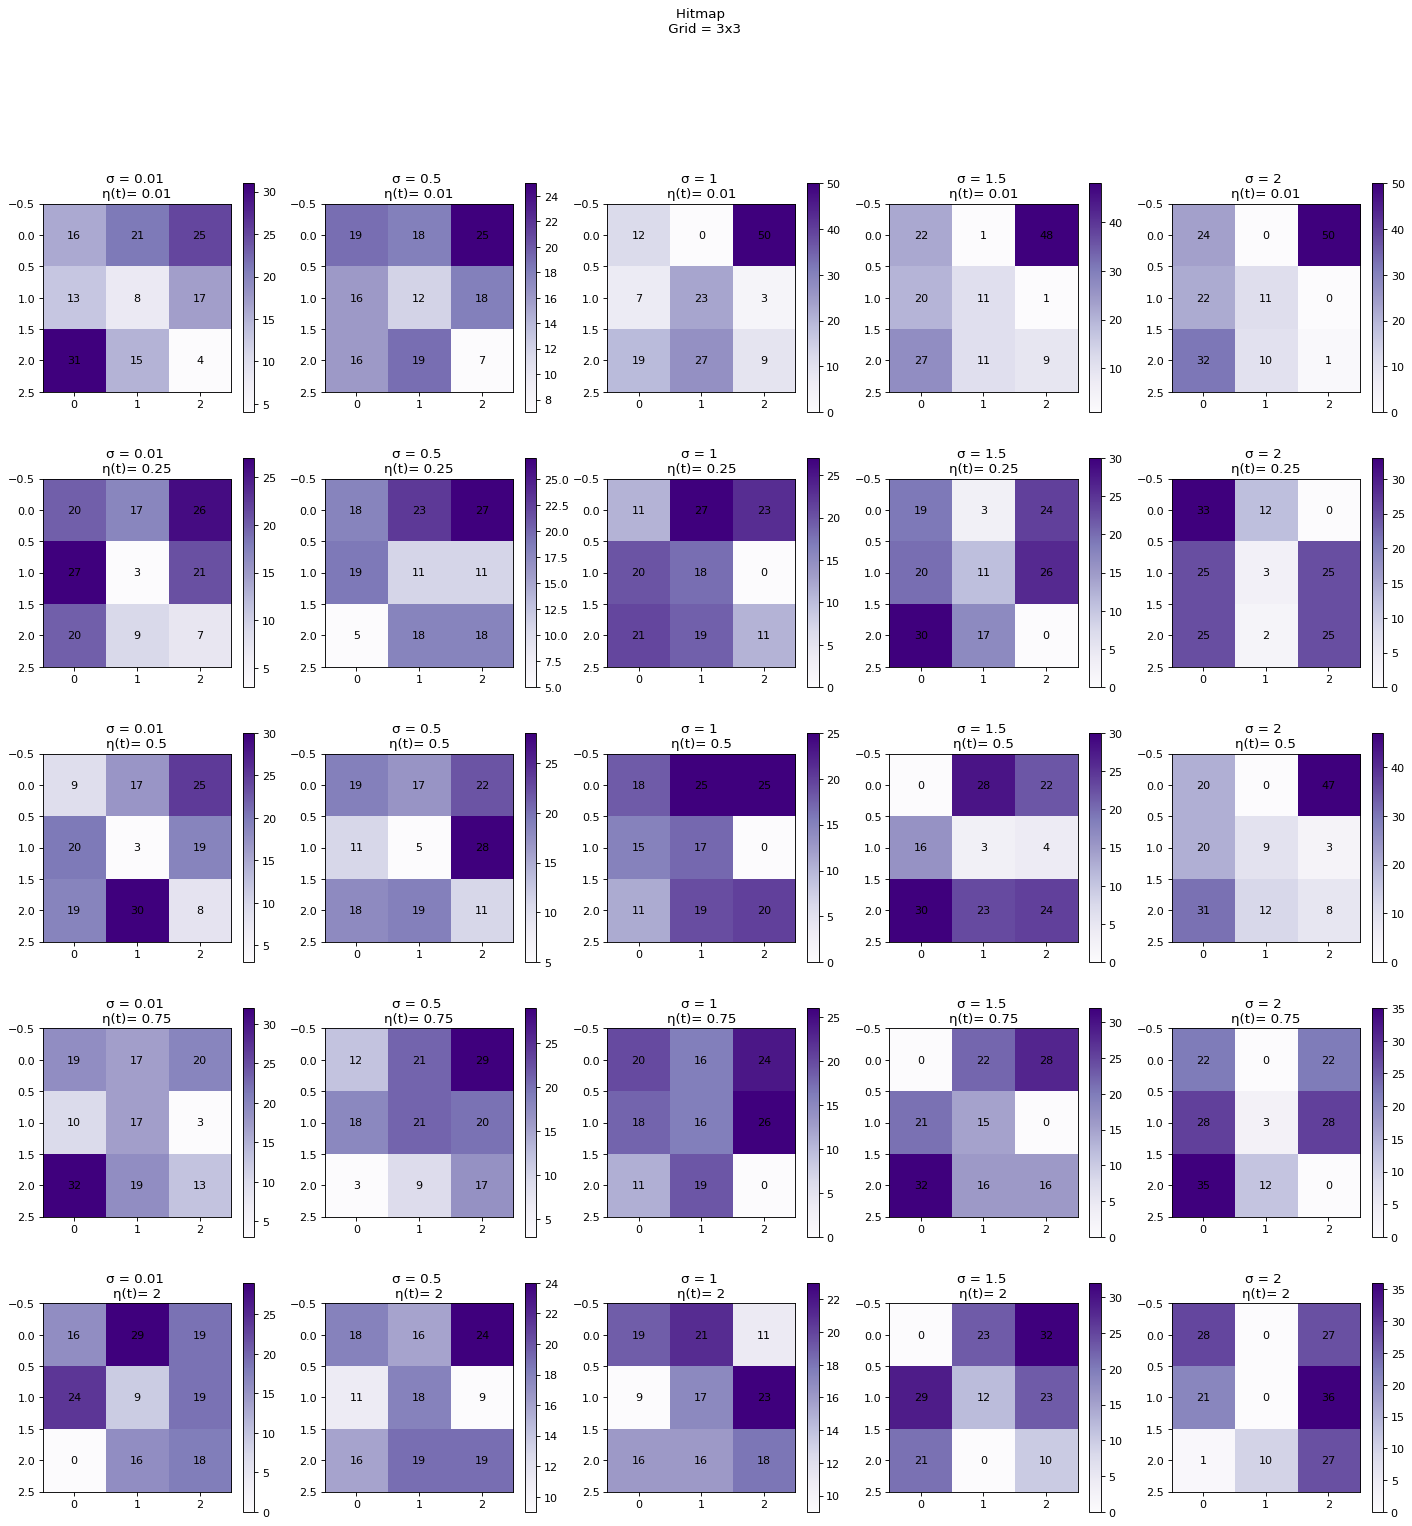

In [ ]:
#i = 0 
figure( figsize=(fig_x,fig_y),dpi=80)
plt.suptitle('Hitmap \n Grid = '+str(n_neurons)+'x'+str(m_neurons))
for k in range(len(sigma)):
  som = som_iris33[k]
  frequencies = som.activation_response(data.values).astype(int)
  frequencies = frequencies.T[::-1]
  plt.subplot(n_rows,n_columns,k+1)
  plt.imshow(frequencies,cmap=color_map)
  plt.colorbar()
  for (i, j), value in np.ndenumerate(frequencies):
          plt.text(j, i, value, verticalalignment='center', 
                                horizontalalignment='center')
  plt.title('σ = '+str(sigma[k])+' \nη(t)= '+str(learning_rate[k]))
plt.show()

### U-Matrix

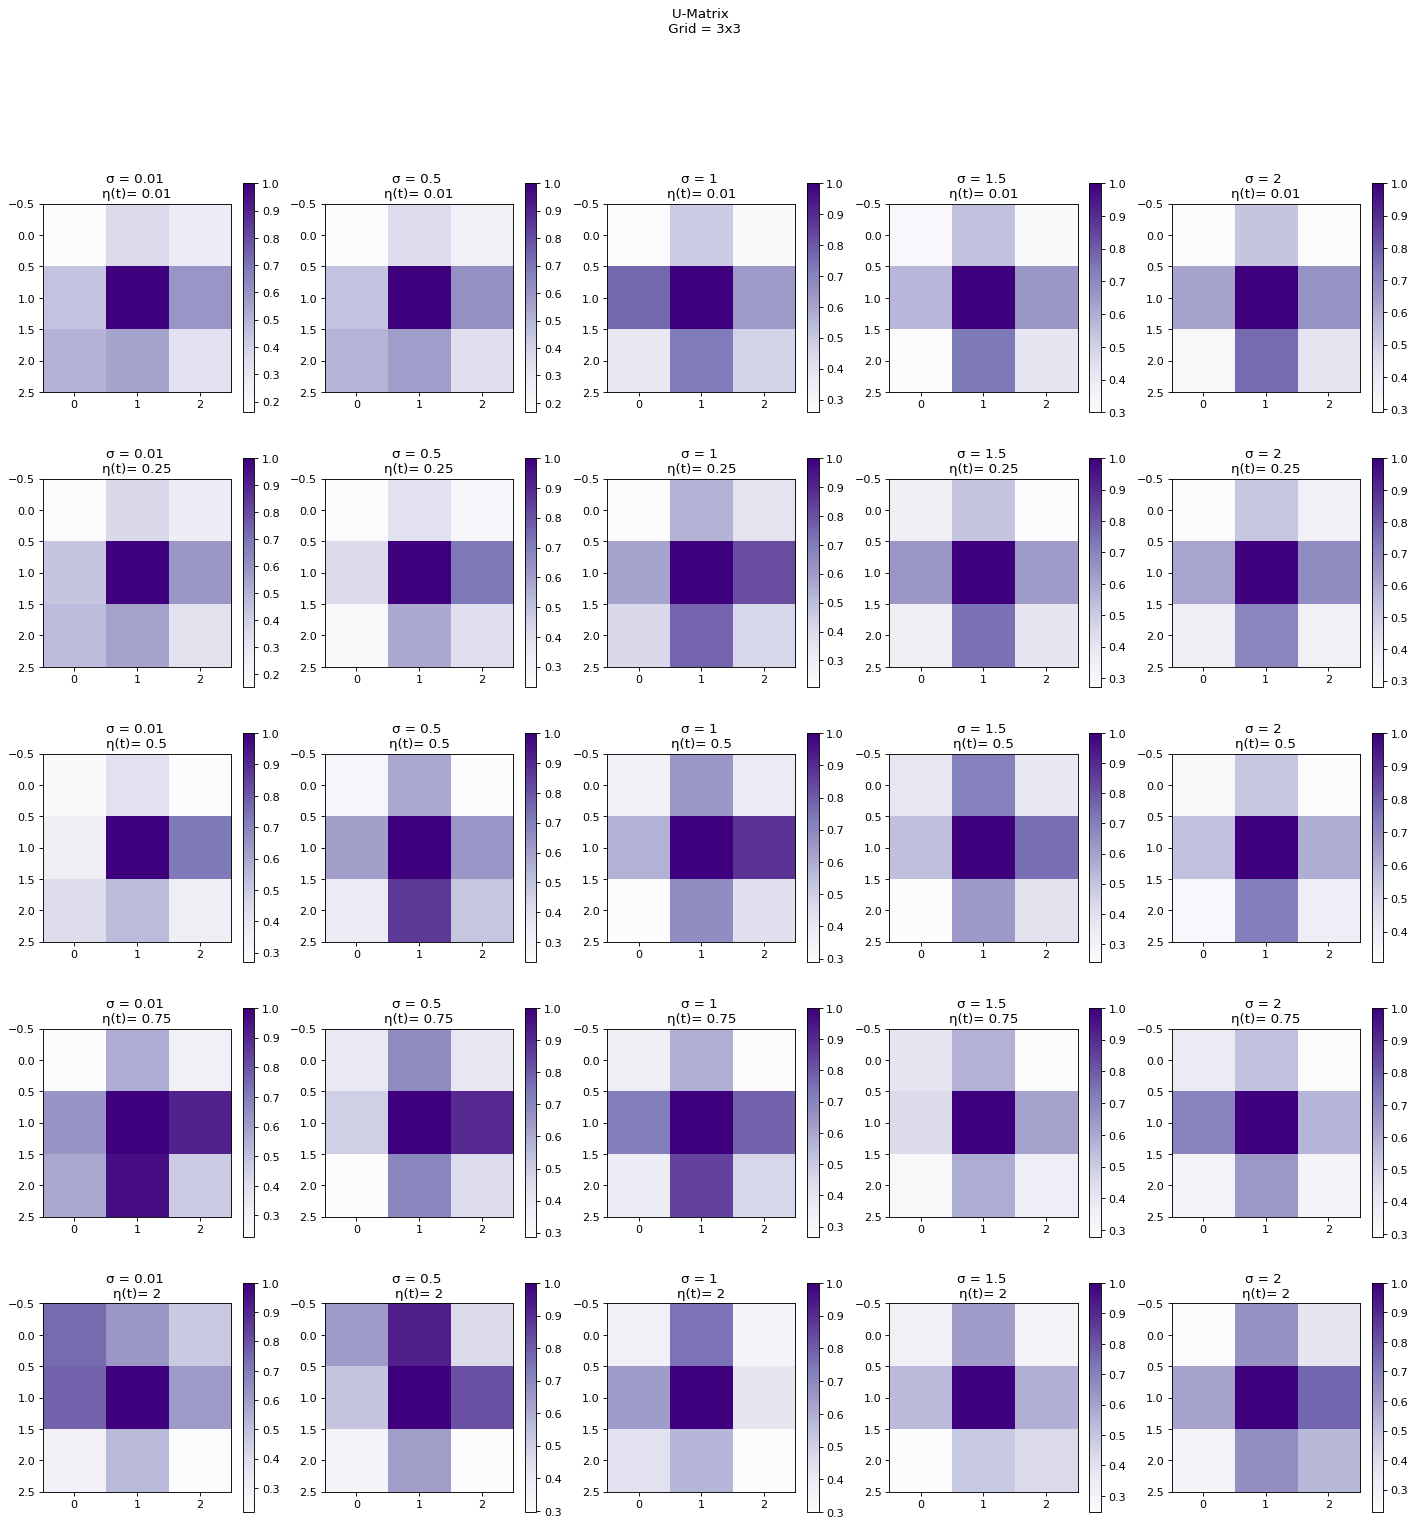

In [ ]:
#i = 0 
figure( figsize=(fig_x,fig_y),dpi=80)
plt.suptitle('U-Matrix \n Grid = '+str(n_neurons)+'x'+str(m_neurons))
for k in range(len(sigma)):
  som = som_iris33[k]
  plt.subplot(n_rows,n_columns,k+1)
  plt.title('σ = '+str(sigma[k])+' \nη(t)= '+str(learning_rate[k]))
  plt.imshow(som.distance_map(),cmap=color_map )
  plt.colorbar()
plt.show()

### Features Maps

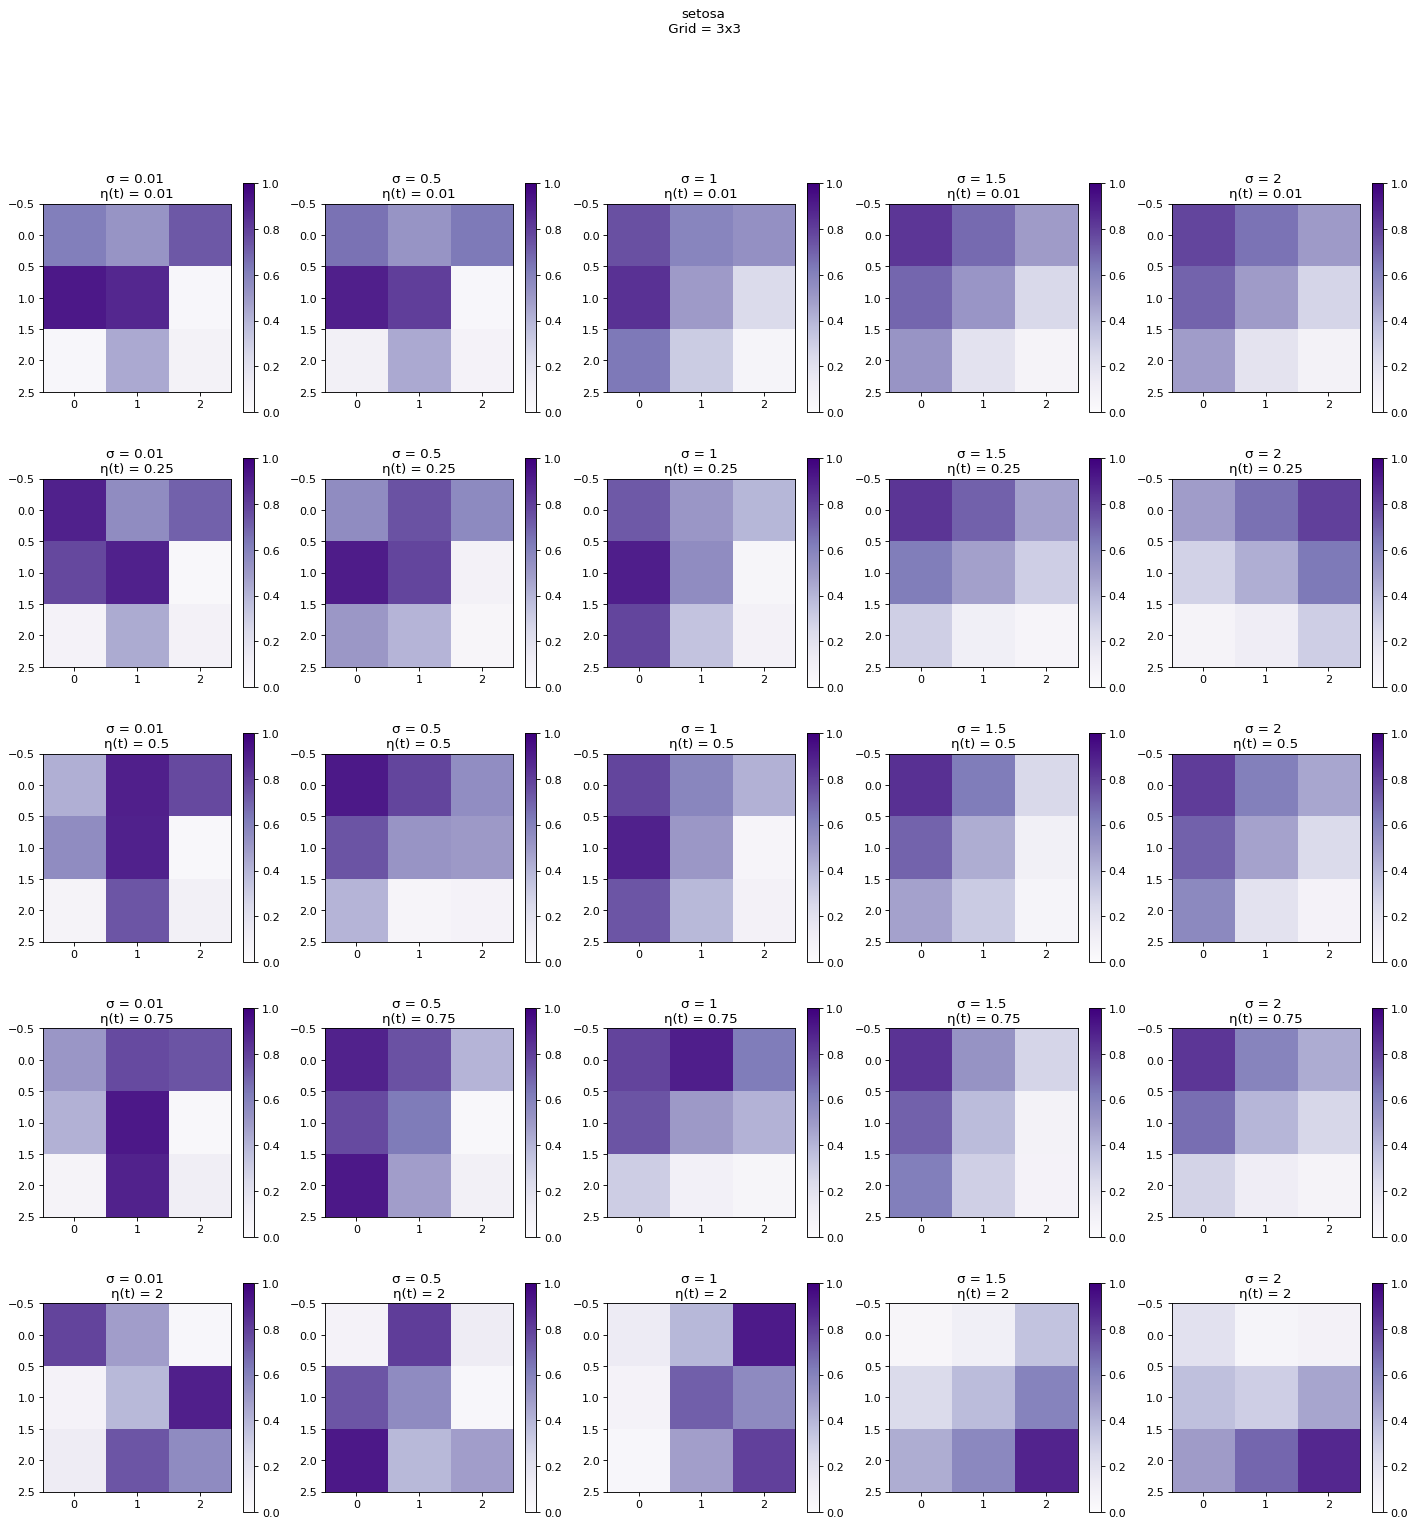

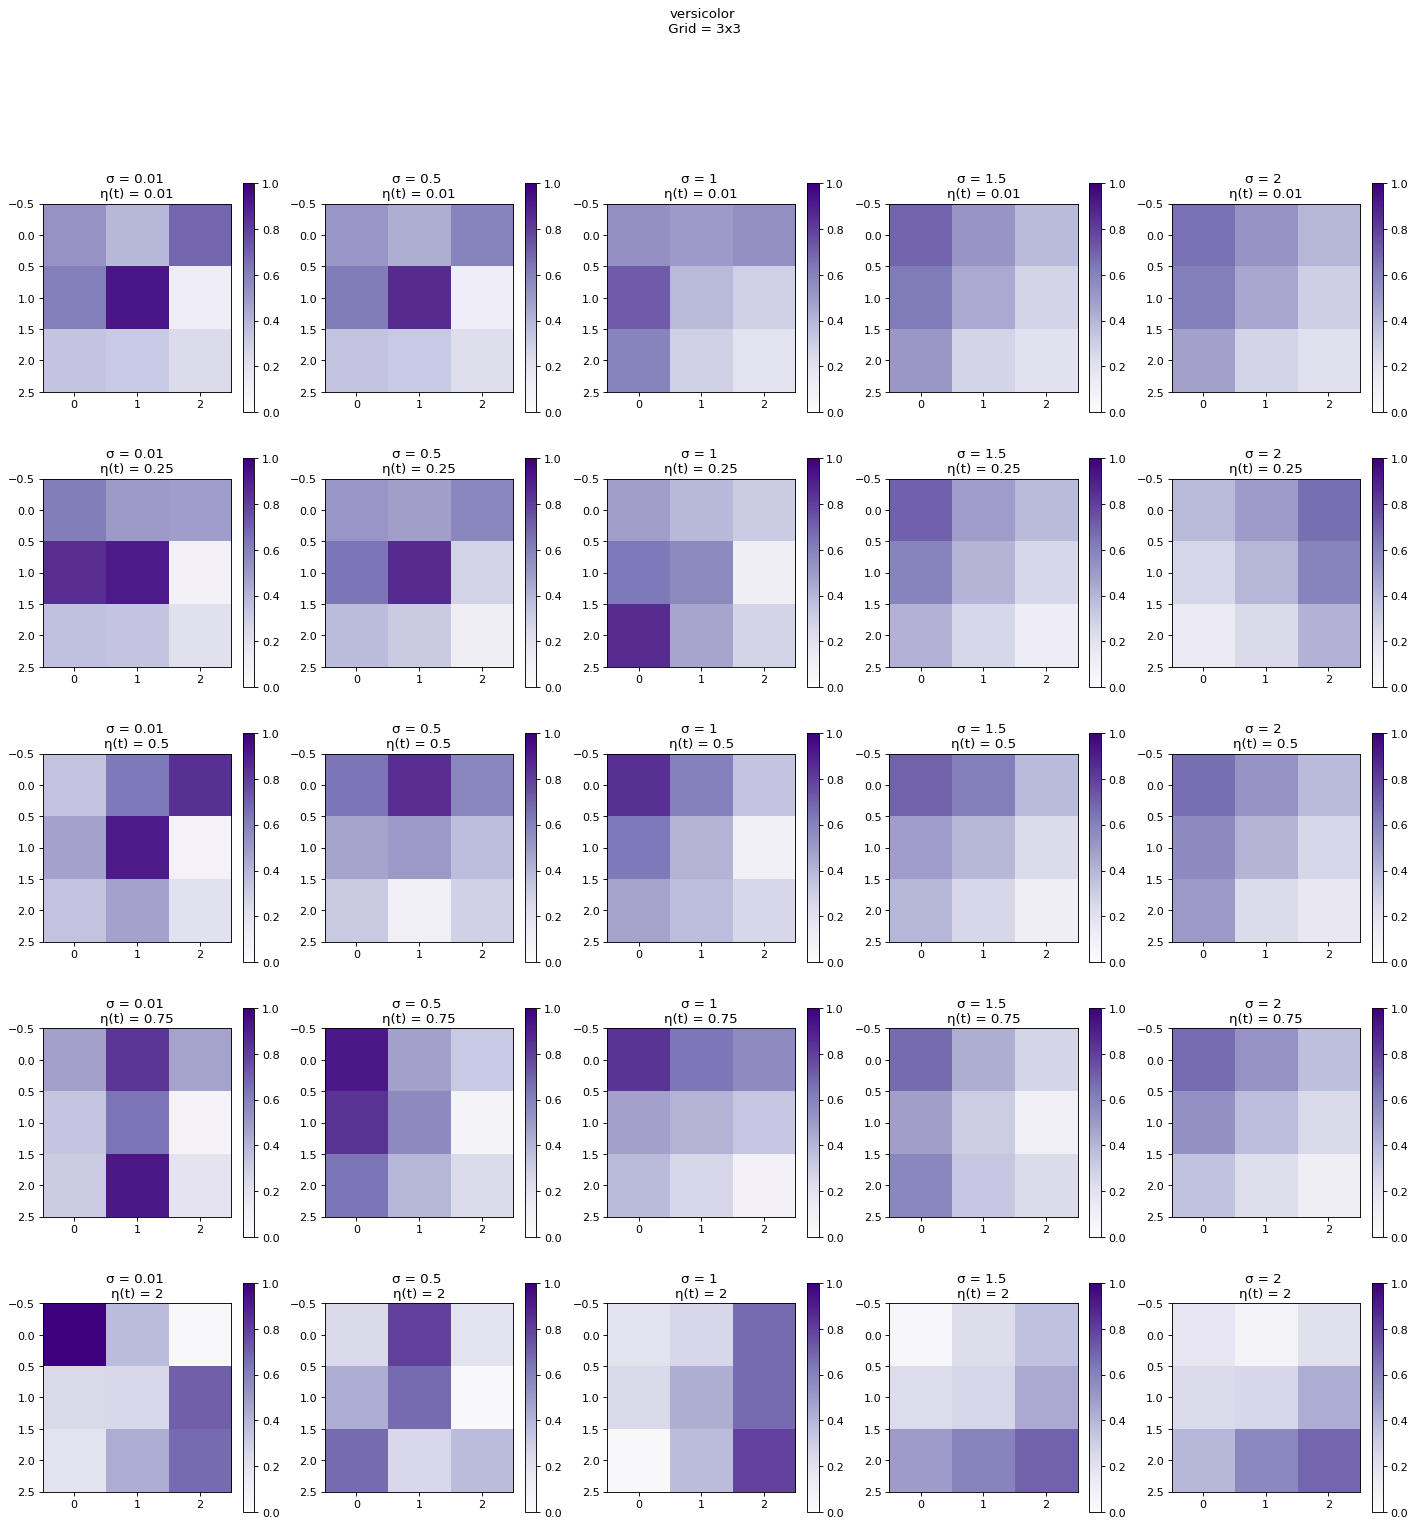

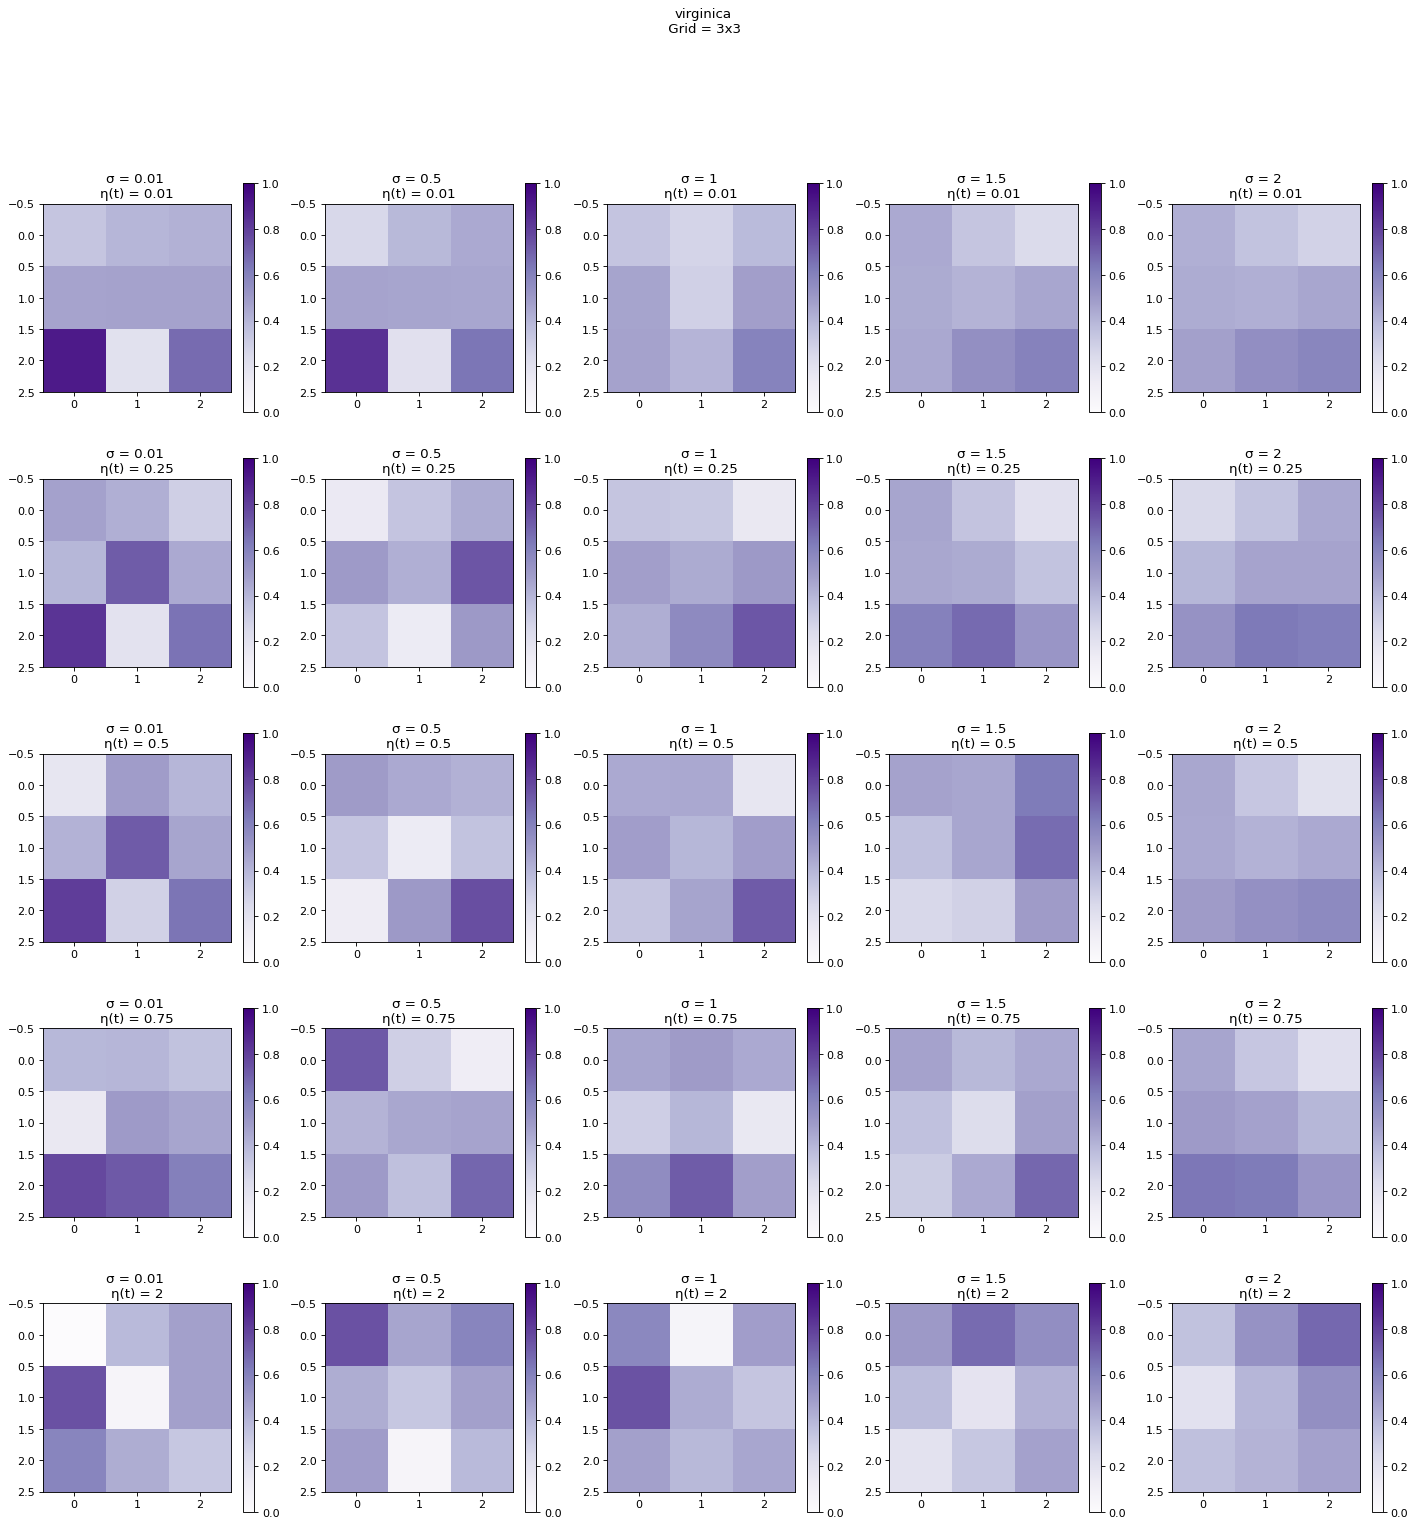

In [ ]:
for l in range(len(labels)):
  figure( figsize=(fig_x,fig_y),dpi=80)
  plt.suptitle(labels[l]+'\n Grid = '+str(n_neurons)+'x'+str(m_neurons))
  for k in range(len(sigma)):
    som = som_iris33[k]
    weights = som.get_weights()

    plt.subplot(n_rows,n_columns,k+1)
    plt.title('σ = '+str(sigma[k])+' \nη(t) = '+str(learning_rate[k]))
    plt.imshow(weights[:, :, l-1], cmap=color_map,vmin=0,vmax=1)
    plt.colorbar() #for plot the bar
  plt.show()

### Seeds map
> Its possible to plot this in a grid way? Just like a have made in other plots



<Figure size 960x960 with 0 Axes>

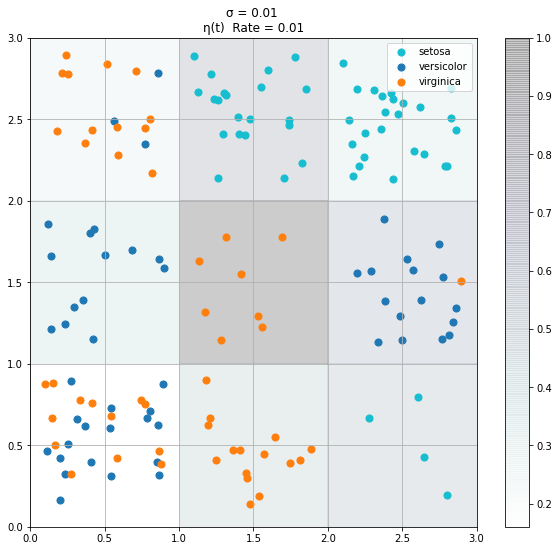

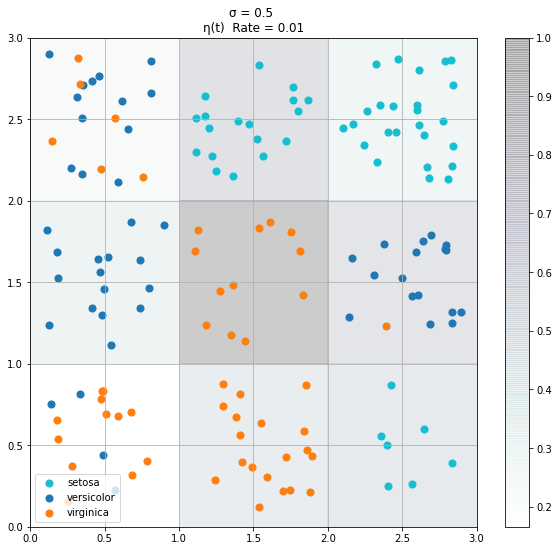

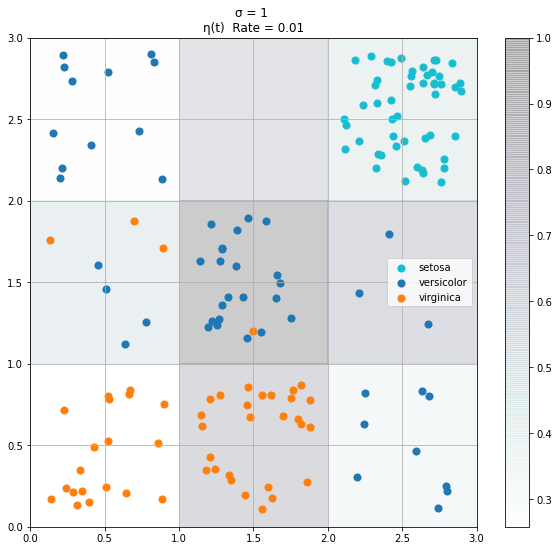

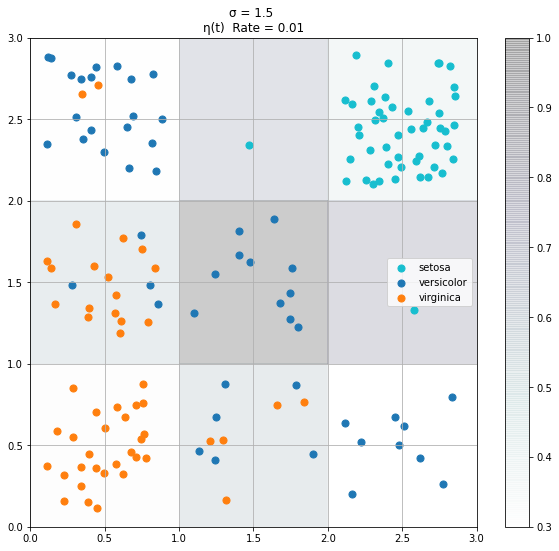

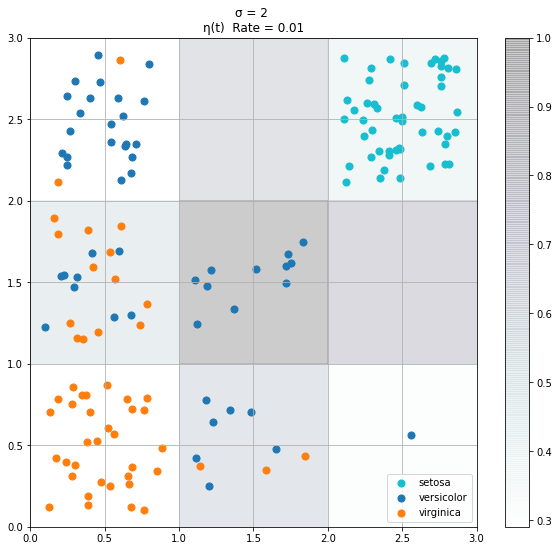

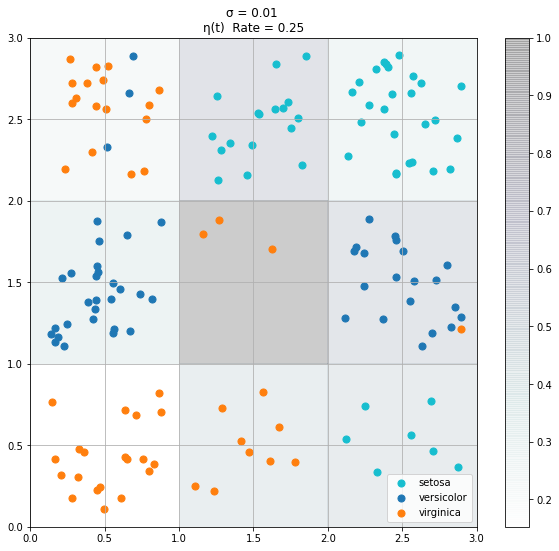

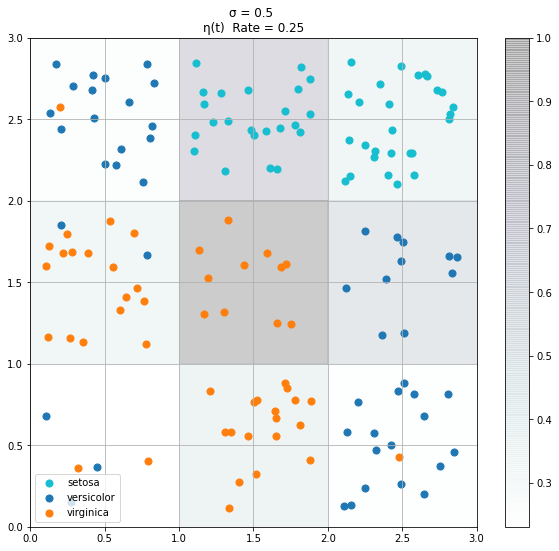

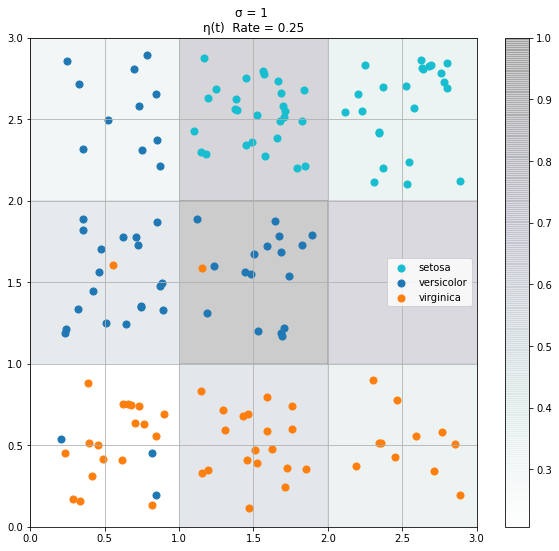

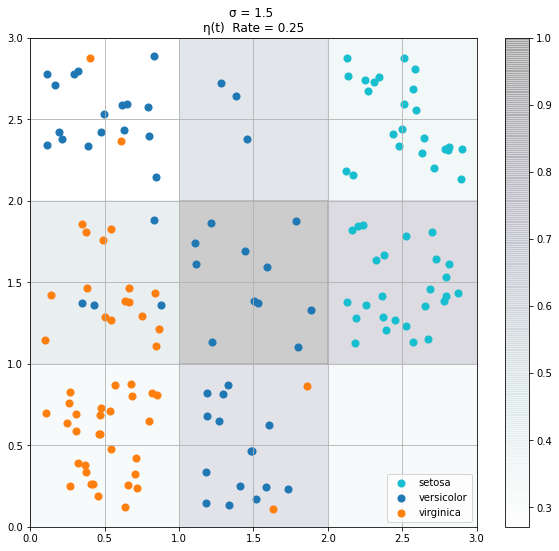

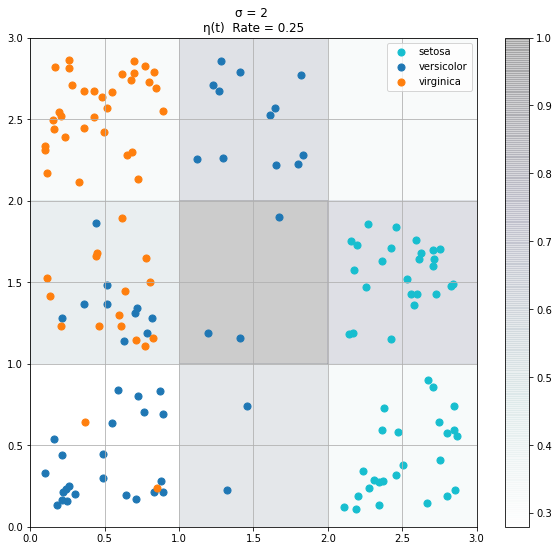

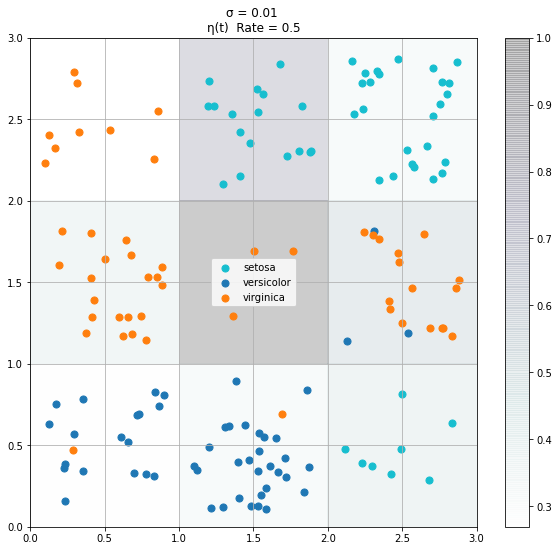

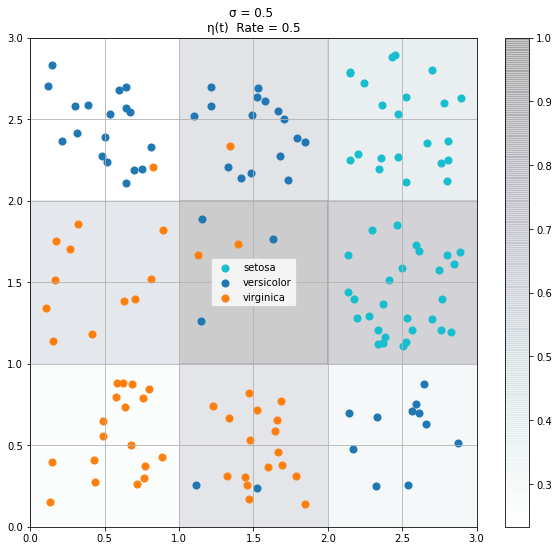

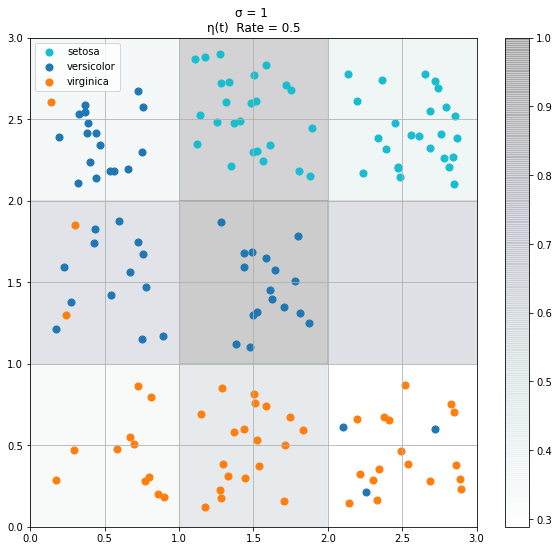

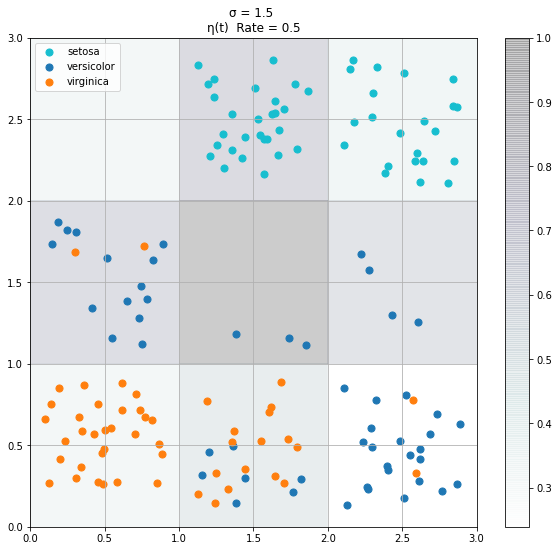

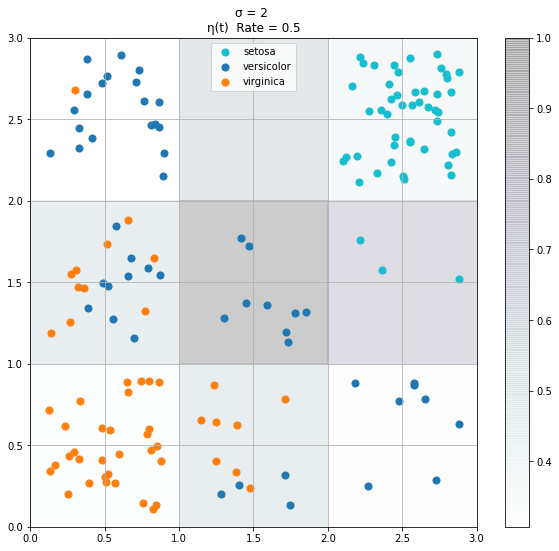

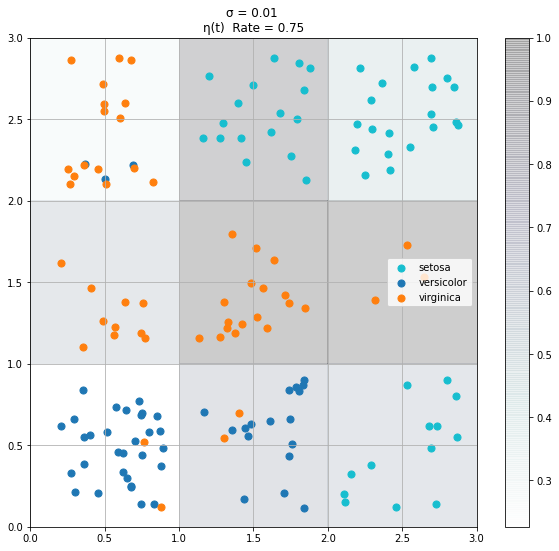

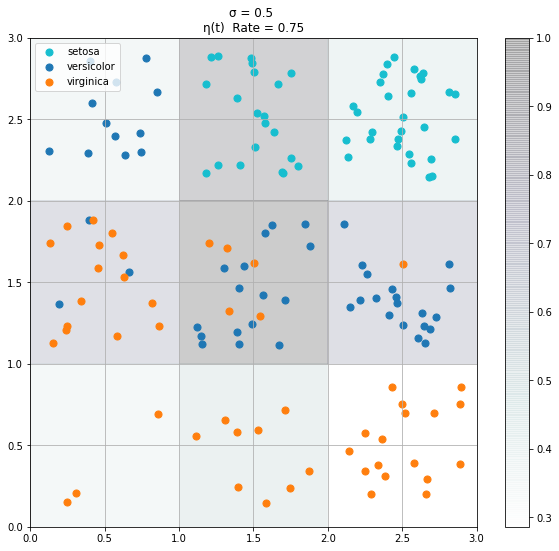

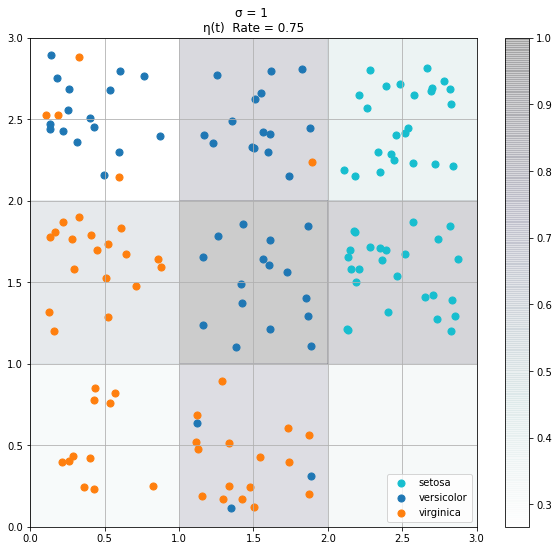

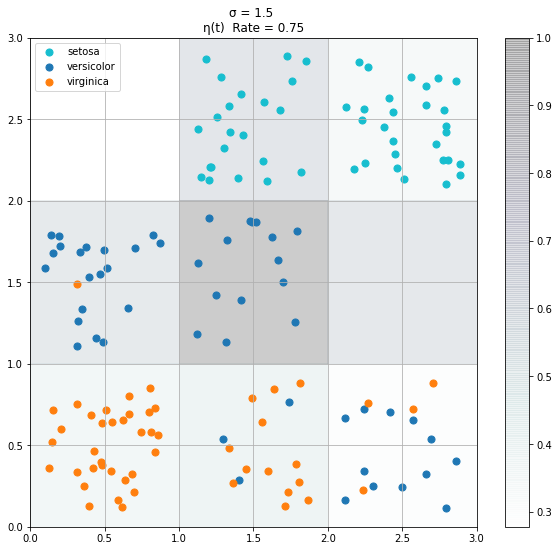

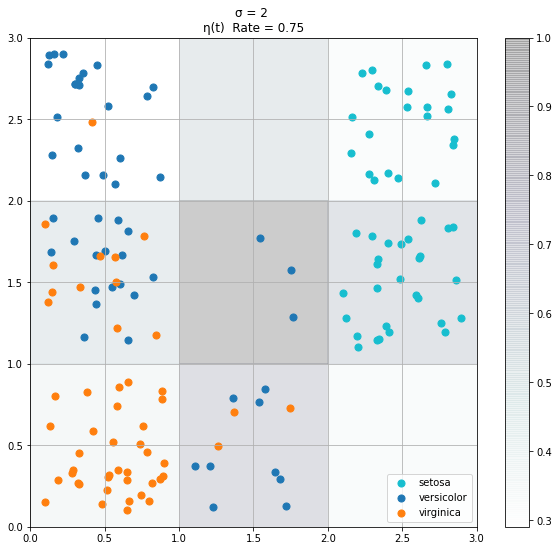

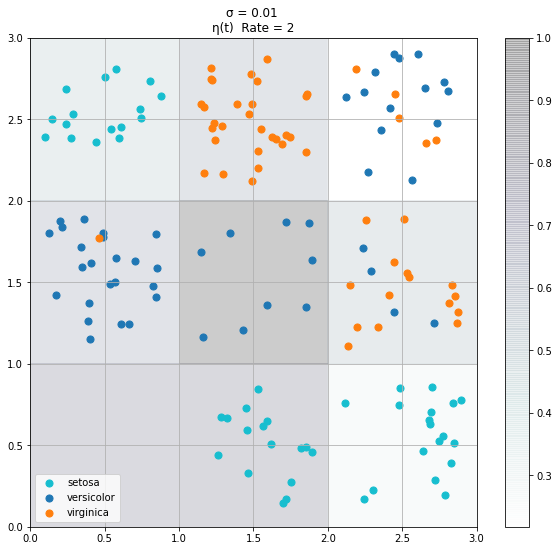

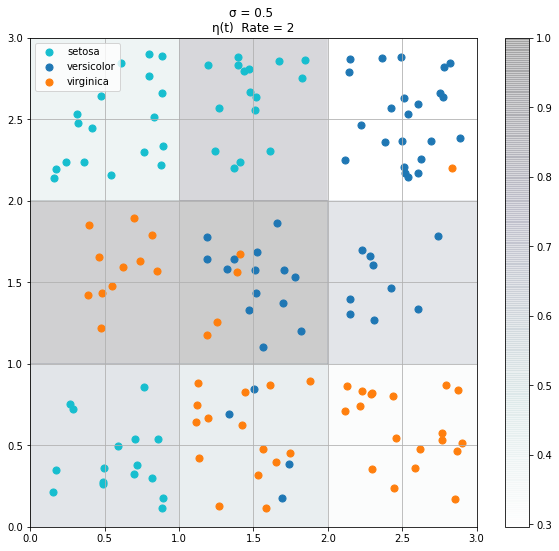

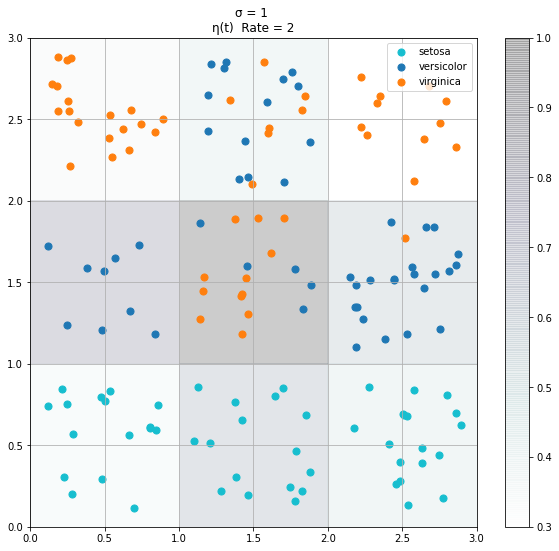

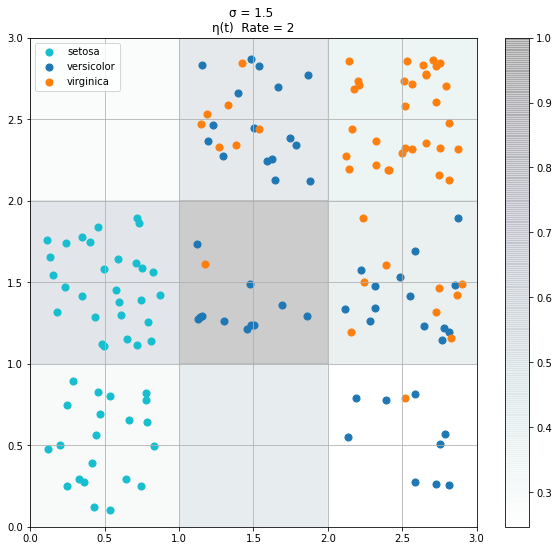

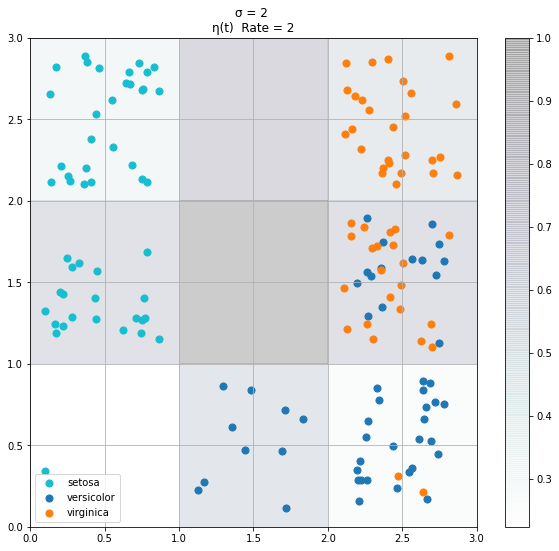

In [ ]:
figure(figsize=(12, 12),dpi=80)
plt.suptitle('Distance Map \n Grid = '+str(n_neurons)+'x'+str(m_neurons))
for k in range(len(sigma)):
  som = som_iris33[k]
  
  w_x, w_y = zip(*[som.winner(d) for d in data.values])
  w_x, w_y = np.array(w_x), np.array(w_y)
  label_names = np.array(labels)
  plt.figure(figsize=(10, 9))
  plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
  plt.colorbar()
  for c in np.unique(target):
      idx_target = target==c
      plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                  w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                  s=50, 
                  c=colors[c-1], 
                  label=label_names[c]
                  )
  plt.legend()#loc='upper right')
  plt.grid()
  plt.title('σ = '+str(sigma[k])+' \nη(t)  Rate = '+str(learning_rate[k]))
  plt.show()

### Starburst Gradient visualization

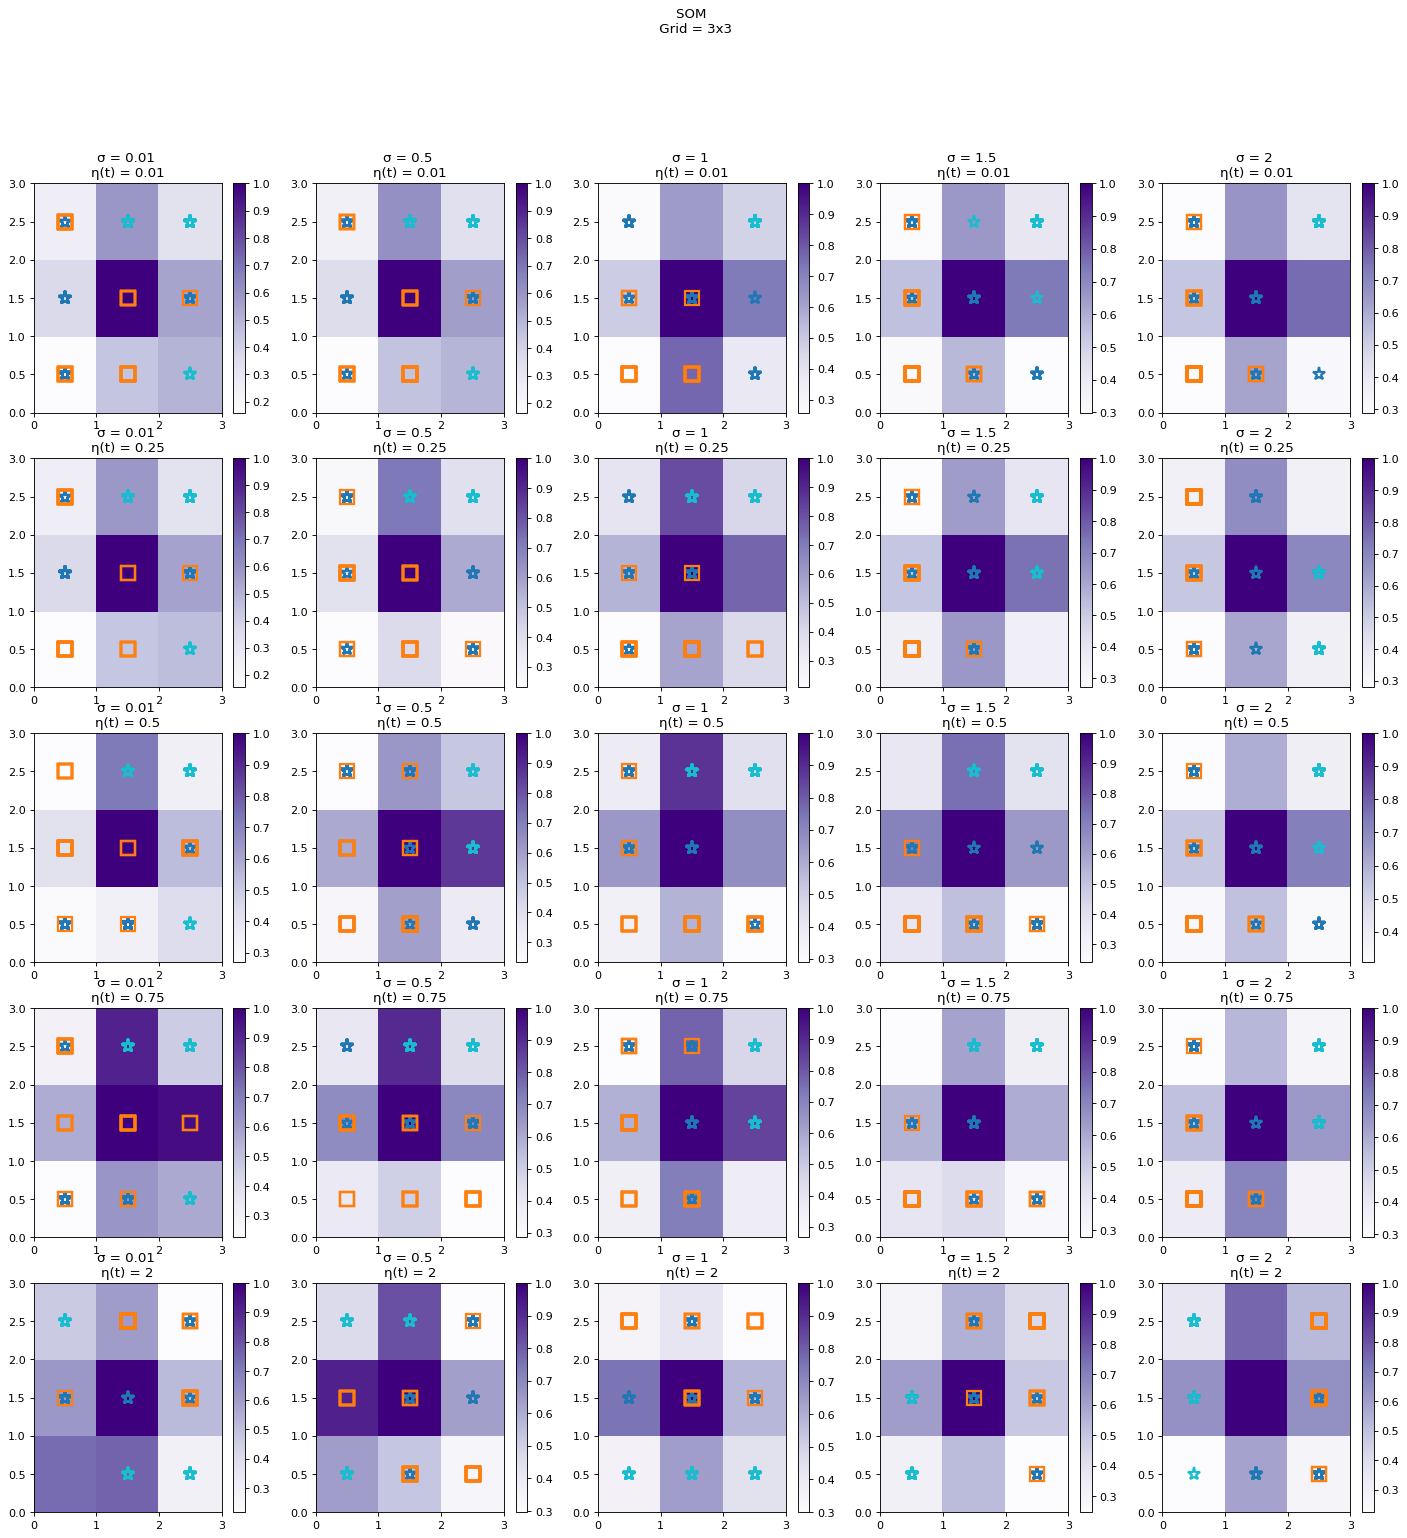

In [ ]:
figure( figsize=(fig_x,fig_y),dpi=80)
plt.suptitle('SOM \n Grid = '+str(n_neurons)+'x'+str(m_neurons))
for k in range(len(sigma)):
  plt.subplot(n_rows,n_columns,(k+1))
  som = som_iris33[k]
  plt.pcolor(som.distance_map().T, cmap=color_map)  # plotting the distance map as background
  plt.colorbar()
  for cnt, xx in enumerate(data.values):
      w = som.winner(xx)  # getting the winner
      # palce a marker on the winning position for the sample xx
      plt.plot(w[0]+.5, w[1]+.5,
               markers[target[cnt]-1],
               markerfacecolor='None',
               markeredgecolor=colors[target[cnt]-1],
               markersize=12, 
               markeredgewidth=2)
  plt.title('σ = '+str(sigma[k])+' \nη(t) = '+str(learning_rate[k]))
plt.show()

### Error Evaluation

/usr/local/lib/python3.7/dist-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)
/usr/local/lib/python3.7/dist-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)
/usr/local/lib/python3.7/dist-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)
/usr/local/lib/python3.7/dist-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)
/usr/local/lib/python3.7/dist-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)
/usr/local/lib/python3.7/dist-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + inp

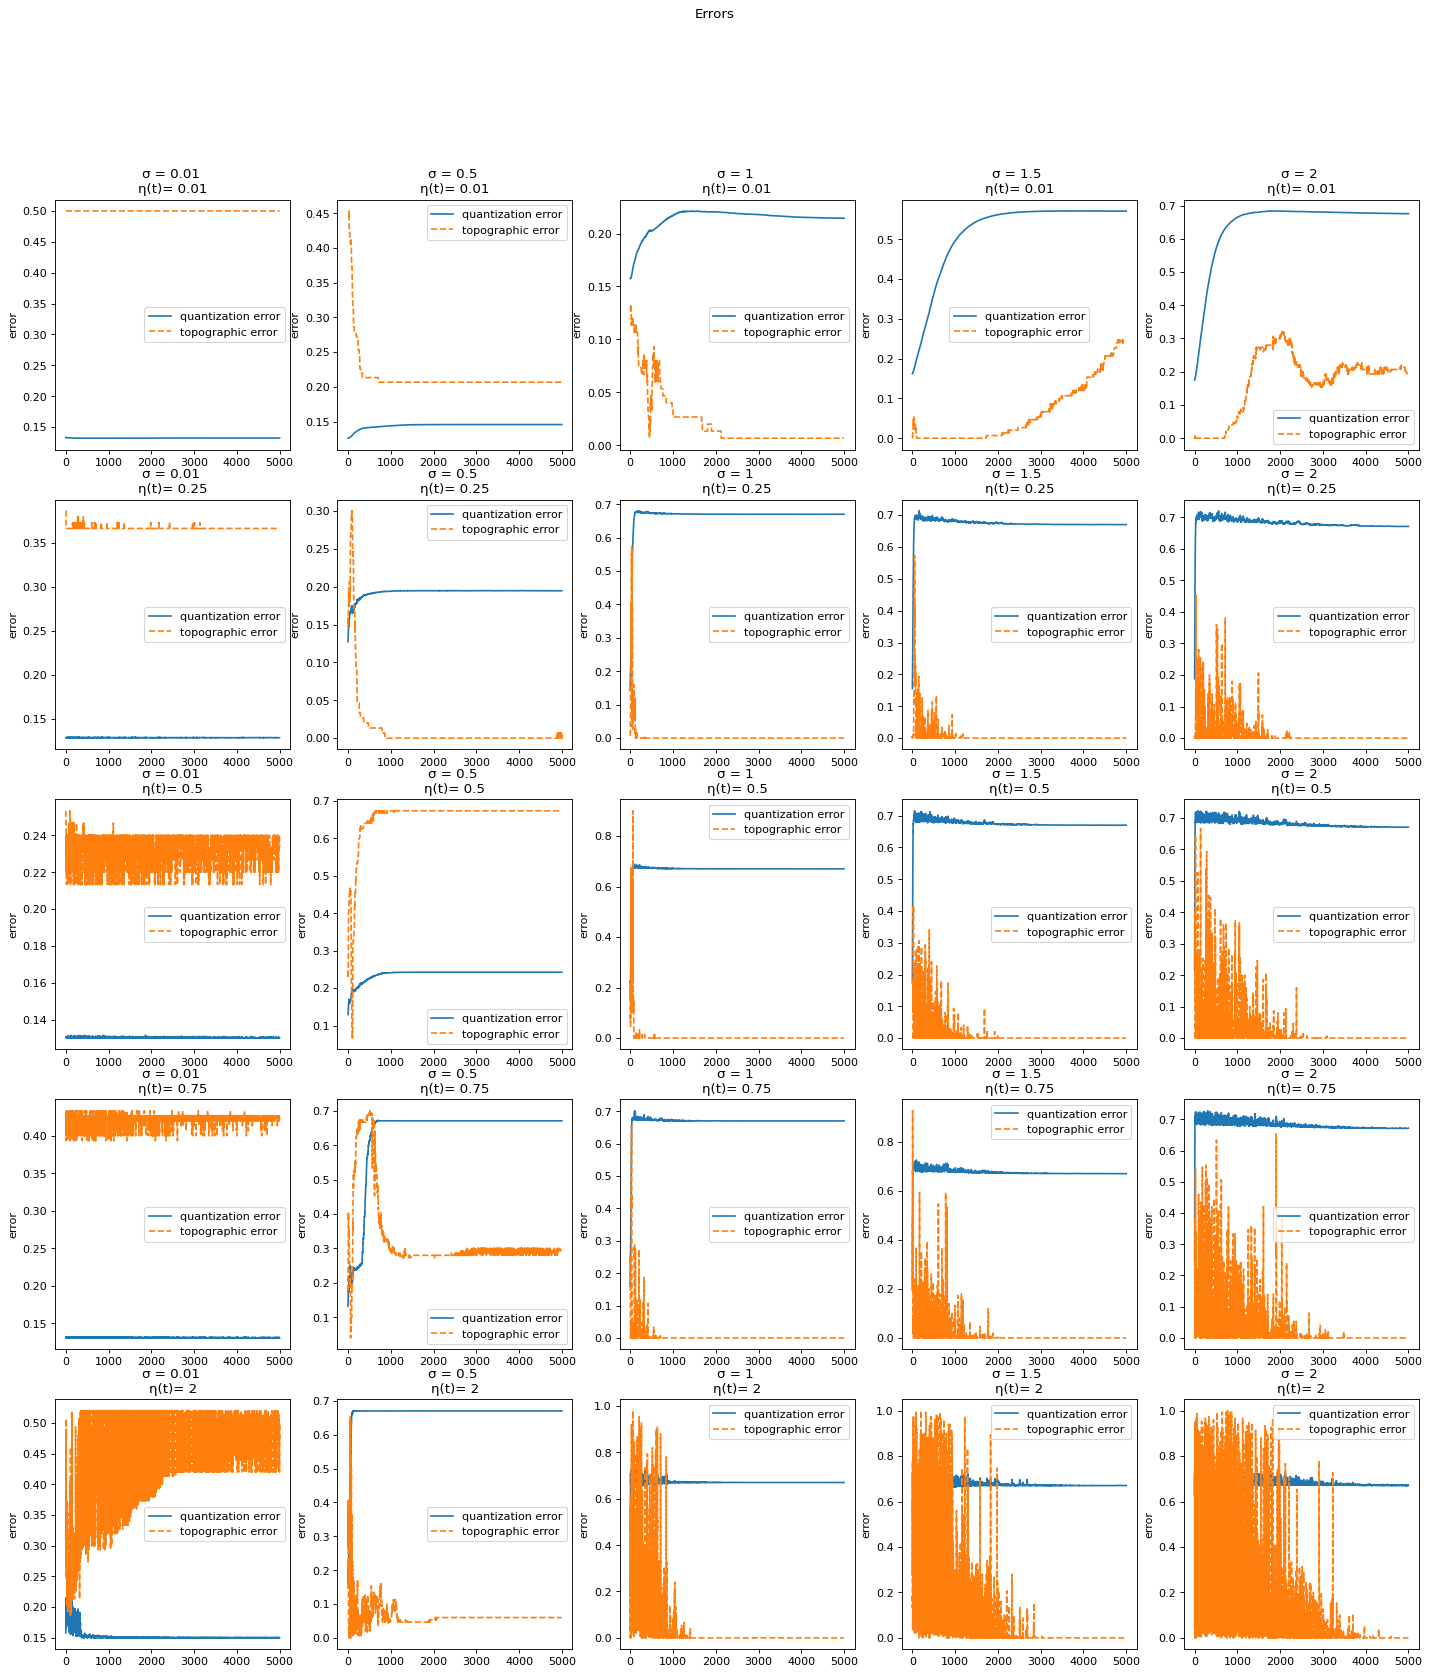

In [ ]:
figure(figsize=(fig_x, fig_y+2),dpi=80)
plt.suptitle('Errors')
for k in range(len(sigma)):
  plt.subplot(n_rows,n_columns,k+1)
  plt.title('σ = '+str(sigma[k])+' \nη(t)= '+str(learning_rate[k]))
  som = som_iris33[k]
  max_iter = epochs
  q_error = []
  t_error = []
  for i in range(max_iter):
      rand_i = np.random.randint(len(data.values[0]))
      som.update(data.values[rand_i], som.winner(data.values[rand_i]), i, max_iter)
      q_error.append(som.quantization_error(data.values))
      t_error.append(som.topographic_error(data.values))

  plt.plot(np.arange(max_iter), q_error, label='quantization error')
  plt.plot(np.arange(max_iter), t_error, label='topographic error' ,linestyle='--')
  plt.ylabel('error')
  #plt.xlabel('iteration index')
  plt.legend()
  #plt.legend()
plt.show()

# References

[HAYKIN, Simon. Redes Neurais: Princípios e prática. Porto Alegre
RS:Bookman, 2001.](https://www.amazon.com.br/Redes-Neurais-Princ%C3%ADpios-Simon-Haykin-ebook/dp/B073QSG69Y)

https://www.w3schools.com/python/python_classes.asp

https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73?gi=21e42fd28916

https://www.kaggle.com/code/phelpsmemo/cap-351-neurocomputacao-projeto4-autoencoder

https://www.kaggle.com/code/rvislaywade/visualizing-mnist-using-a-variational-autoencoder

https://youtu.be/Ey8IZQl_lKs


